In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation

import torch
import torch.nn

import torchsummary

from tqdm.notebook import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print(device)

torch.manual_seed(0)
np.random.seed(0)

cpu


In [2]:
pos_hoop = torch.tensor([0, 0.8]).to(device, dtype)

idxs_op = torch.arange(5).to(device)
idxs_dp = torch.arange(5, 10).to(device)
idxs_ball = torch.tensor([10]).to(device)

idxs_oentities = torch.cat((idxs_op, idxs_ball)).to(device)


fps = 10
duration = 5
num_game_steps = fps * duration

radius_player = 0.05
radius_ball = 0.04


def random_initial_game_state(batch_size, only_game_state=True):
    pos_op = torch.rand(batch_size, len(idxs_op), 2, device=device)*2 - 1
    pos_dp = torch.rand(batch_size, len(idxs_dp), 2, device=device)*2 - 1
    pos_ball = torch.rand(batch_size, len(idxs_ball), 2, device=device)*2 - 1
    
    init_game_state = torch.cat((pos_op, pos_dp, pos_ball), dim=1)
    
    if only_game_state:
        return init_game_state
    else:
        return init_game_state, pos_op, pos_dp, pos_ball

# Game Visualization

In [3]:
def show_game_state(game_state, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8)) # note we must use plt.subplots, not plt.subplot
    # (or if you have an existing figure)
#     fig = plt.gcf()
#     ax = fig.gca()
    
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    
    for idx_op in idxs_op.numpy():
        x, y = game_state[idx_op]
        circle = plt.Circle((x, y), radius=radius_player, color='b')
        ax.add_artist(circle)
    for idx_dp in idxs_dp.numpy():
        x, y = game_state[idx_dp]
        circle = plt.Circle((x, y), radius=radius_player, color='r')
        ax.add_artist(circle)
    for idx_ball in idxs_ball.numpy():
        x, y = game_state[idx_ball]
        circle = plt.Circle((x, y), radius=radius_ball, color='orange')
        ax.add_artist(circle)
    
    ax.add_artist(plt.Circle(pos_hoop.numpy(), radius=0.1, color='orange', fill=False))
    
    ax.set_title('Game State')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    return ax


def show_game_animation(all_game_states, fps=10):
    num_games = len(all_game_states)
    fig, axs = plt.subplots(1, num_games, figsize=(2*num_games, 2))
    
    all_entities = []
    for ax in axs:
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.add_artist(plt.Circle(pos_hoop.numpy(), radius=0.1, color='orange', fill=False))
        
        entities = []
        for _ in idxs_op.numpy():
            circle = plt.Circle((0, 0), radius=radius_player, color='b')
            entities.append(circle)
        for _ in idxs_dp.numpy():
            circle = plt.Circle((0, 0), radius=radius_player, color='r')
            entities.append(circle)
        for _ in idxs_ball.numpy():
            circle = plt.Circle((0, 0), radius=radius_ball, color='orange')
            entities.append(circle)
            
        all_entities.append(entities)
    
    time_text = axs[num_games//2].text(0., -0.9, '')
    
    
    def init():
        for idx_ax, ax in enumerate(axs):
            entities = all_entities[idx_ax]
            for idx_entity, entity in enumerate(entities):
                pos = all_game_states[idx_ax, 0, idx_entity, :]
                entity.center = (pos[0].item(), pos[1].item())
                ax.add_artist(entity)
                
        time_text.set_text(f'{0} sec')
        return entities + [time_text]

    def animate(game_step):
        for idx_ax, ax in enumerate(axs):
            entities = all_entities[idx_ax]
            for idx_entity, entity in enumerate(entities):
                pos = all_game_states[idx_ax, game_step, idx_entity, :]
                entity.center = (pos[0].item(), pos[1].item())
                
        time_text.set_text(f'{game_step/fps} sec')
        return entities + [time_text]
    
    anim = matplotlib.animation.FuncAnimation(fig,animate, init_func=init, frames=num_game_steps, blit=True, interval=1000/fps)
    return anim

# Model Definitions

In [4]:
def get_dense_layers(num_features):
    acts = [torch.nn.Tanh() for num_out in num_features[1:-1]]
    acts.append(torch.nn.Identity())
    layers = []
    for num_in, num_out, act in zip(num_features, num_features[1:], acts):
        layers.extend((torch.nn.Linear(num_in, num_out), act))
    return torch.nn.Sequential(*layers)

class OffenseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = get_dense_layers([11*2, 100, 100, 6*2])
    def forward(self, X):
        X = X.view(-1, 11*2)
        X = self.main(X)
        X = X.view(-1, 6, 2)
        X[:, idxs_op, :] = 0.3 * torch.tanh(X[:, idxs_op, :])
        return X
    
class DefenseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = get_dense_layers([11*2, 100, 100, 5*2])
    def forward(self, X):
        X = X.view(-1, 11*2)
        X = self.main(X)
        X = X.view(-1, 5, 2)
        X = 0.3 * torch.tanh(X)
        return X
    
model_o = OffenseModel().to(device)
model_d = DefenseModel().to(device)

print('Offensive Coach Model Summary: ')
torchsummary.summary(model_o, input_size=(11, 2))
print('Defensive Coach Model Summary: ')
torchsummary.summary(model_d, input_size=(11, 2))


Offensive Coach Model Summary: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]           2,300
              Tanh-2                  [-1, 100]               0
            Linear-3                  [-1, 100]          10,100
              Tanh-4                  [-1, 100]               0
            Linear-5                   [-1, 12]           1,212
          Identity-6                   [-1, 12]               0
Total params: 13,612
Trainable params: 13,612
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.06
----------------------------------------------------------------
Defensive Coach Model Summary: 
----------------------------------------------------------------
        Layer (type)               Output S

# Loss Functions

In [18]:
# general functions
def distance(pos, pos_base=pos_hoop):
    """Computes the distance between pos and pos_base.
    pos should be of shape (..., 2)
    pos_base should be of shape (..., 2)
    pos and pos_base should be broadcastable to each other. """
    return (pos-pos_base).norm(dim=-1)
def direction(pos, pos_base=pos_hoop):
    """Computes the direction of pos from pos_base.
    pos should be of shape (..., 2)
    pos_base should be of shape (..., 2)
    pos and pos_base should be broadcastable to each other. """
    locations = pos - pos_base
    return torch.atan2(locations[..., 1], locations[..., 0]+0.0001) # TODO: change this to be more stable
def polar_coordinates(pos, pos_base=pos_hoop):
    """Computes the distance and angle of pos from pos_base.
    pos should be of shape (..., 2)
    pos_base should be of shape (..., 2)
    pos and pos_base should be broadcastable to each other. """
    return hoop_distance(pos, pos_base), hoop_direction(pos, pos_base)

# basketball functions
def raw_accuracy(pos_op, pos_base=pos_hoop):
    """The accuracy of a player at pos_op, given the hoop is at pos_base.
    pos_op should be of shape (..., 2)
    pos_base should be of shape (..., 2)
    pos_op and pos_base should be broadcastable to each other. """
    r = distance(pos_op, pos_base)
    accuracy = 1/torch.exp(r)
    return accuracy
def raw_points(pos_op, pos_base=pos_hoop):
    """The amount of points a player at pos_op will score, given the basket is at pos_base.
    pos_op should be of shape (..., 2)
    pos_base should be of shape (..., 2)
    pos_op and pos_base should be broadcastable to each other. """
    r = distance(pos_op, pos_base)
    point_scale = 2 + 1 / (1 + torch.exp(-50 * (r-0.9)))
    return point_scale

def raw_contest_distance(dist):
    """The contest coefficient a player will feel if someone is dist away from them.
    dist can be of any shape. """
    return 1 - torch.exp(-50*dist)
def raw_contest_angle(theta):
    """The contest coefficient a player will feel if someone is theta degrees away from the direction of the.
    theta can be of any shape. """
    
    high = .8
    low = .4
    return (torch.cos(theta-np.pi)+1)/2.*(high-low)+low

def contest(pos_op, pos_dp, pos_base=pos_hoop):
    """The contest a player at pos_op will feel with defenders at pos_dp, given the basket is at pos_base.
    pos_op should be of shape (..., 2)
    pos_dp should be of shape (..., 2)
    pos_base should be of shape (..., 2)
    pos_op, pos_dp, and pos_base should be broadcastable to each other. """
    
    theta_hoop = direction(pos_base, pos_op) # theta of hoop from op
    theta_defender = direction(pos_dp, pos_op) # theta of dp from op
    
    contest_directional = raw_contest_angle(theta_hoop - theta_defender) # directional contest on op from dp
    
    r = distance(pos_dp, pos_op) # distance of dp from op
    contest_distance = raw_contest_distance(r) # distance contest on op from dp
    
    weight = torch.tanh(3*r) # weight two combination of terms based on distance of dp from op
    return weight*contest_distance + (1-weight)*contest_directional

def points_per_possession(pos_op, pos_dp, pos_base=pos_hoop):
    """The points per possession a player at pos_op has with defenders at pos_dp and hoop at pos_base.
    pos_op should be of shape (..., 2)
    pos_dp should be of shape (..., 2)
    pos_base should be of shape (..., 2)
    pos_op, pos_dp, and pos_base should be broadcastable to each other. """
    
    # points per posession
    no_contest_ppp = raw_accuracy(pos_op, pos_base) * raw_points(pos_op, pos_base)
    contest_coeff = contest(pos_op, pos_dp, pos_base)
    contest_coeff = contest_coeff.prod(dim=-1)[..., None] # all dps contest all ops
    return (contest_coeff * no_contest_ppp)

In [6]:

def loss_function_dribble_pass(all_game_states):
    # batch, game_steps, player, pos
    pos_op = all_game_states[:, :, idxs_op, :]
    pos_dp = all_game_states[:, :, idxs_dp, :]
    pos_ball = all_game_states[:, :, idxs_ball, :]
    
    pos_all = all_game_states[:, :, :, :]
    
    dist_ball_op = (pos_ball - pos_op).norm(dim=-1) # batch, game_steps, player
    dist_closest_dribbler, _ = dist_ball_op.min(dim=-1) # batch, game_steps
    dribbling_frames = dist_closest_dribbler <= (radius_player+radius_ball)
#     print(dribbling_frames.shape)
    
    vel = all_game_states[:, 1:, :, :] - all_game_states[:, :-1, :, :]
    speed = vel.norm(dim=-1)
    loss_o = -speed.mean()
    loss_d = -speed.mean()

#     loss_o += pos_all[:, -1, :, :].norm(dim=-1).mean()
#     loss_d += pos_all[:, -1, :, :].norm(dim=-1).mean()
    
    
#     return loss_o, loss_d
    return 0., 0.

def loss_function_shot(last_game_state):
    # batch, player, pos
    pos_op = last_game_state[:, idxs_op, :]
    pos_dp = last_game_state[:, idxs_dp, :]
    pos_ball = last_game_state[:, idxs_ball, :]
    
    dist_op_ball = (pos_op - pos_ball).norm(dim=-1)
    _, idx_ball_handler = dist_op_ball.min(dim=-1)
    
    idx_all_batches = torch.arange(len(last_game_state))
    pos_op_dribbler = pos_op[idx_all_batches, idx_ball_handler] [:, None, :]
    
    
    ppp = points_per_possession(pos_op_dribbler, pos_dp)
    ppp = ppp.mean()
    return -ppp, ppp

def loss_function(all_game_states):
    # batch, game_steps, player, pos
    loss_o, loss_d = 0., 0.
    
    loss_dp_o, loss_dp_d = loss_function_dribble_pass(all_game_states)
    loss_shot_o, loss_shot_d = loss_function_shot(all_game_states[:, -1, :, :])
    
    loss_o += loss_dp_o + loss_shot_o
    loss_d += loss_dp_d + loss_shot_d
    return loss_o, loss_d



# Simulation

In [7]:
def run_simulation(model_o, model_d, init_game_state, with_grad=False, return_all_game_states=True, save_anim_location=None, anim_batch_idx=0, pbar=None):
    if return_all_game_states:
        all_game_states = [init_game_state]
    
    if save_anim_location is not None:
        fig, ax = plt.subplots()
        !mkdir {save_anim_location}
        
        
    current_game_state = init_game_state
    with torch.set_grad_enabled(with_grad):
        
        if pbar is not None:
            pbar.reset(total=num_game_steps-1)
        for game_step in range(num_game_steps-1):
            move_o = model_o(current_game_state)
            move_d = model_d(current_game_state)

            current_game_state = current_game_state.clone()
            current_game_state[:, idxs_oentities, :] += move_o
            current_game_state[:, idxs_dp, :] += move_d
            current_game_state = current_game_state.clamp(-1, 1)
            
            if return_all_game_states:
                all_game_states.append(current_game_state)
                
            if save_anim_location is not None:
                show_game_state(current_game_state[0], ax=plt.gca())
                plt.savefig(f'{save_anim_location}/{game_step}.png')
                plt.cla()
                
            if pbar is not None:
                pbar.update()
                
    if save_anim_location is not None:
        plt.close()
        !ffmpeg -framerate 10 -i {save_anim_location}/%d.png {save_anim_location}/animation.gif
                
    if return_all_game_states:
        all_game_states = torch.stack(all_game_states, dim=1)
        return all_game_states
    else:
        return current_game_state
        

# Optimization

O Loss: -1.2637571096420288, D Loss: 1.2637571096420288



<IPython.core.display.Javascript object>


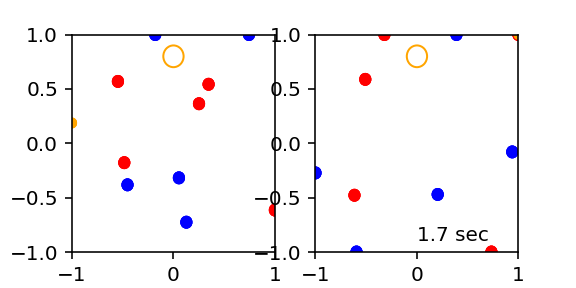

In [8]:
init_game_state = random_initial_game_state(batch_size=2)
all_game_states = run_simulation(model_o, model_d, init_game_state, pbar=tqdm())

loss_o, loss_d = loss_function(all_game_states)
print(f'O Loss: {loss_o.item()}, D Loss: {loss_d.item()}')


%matplotlib notebook
anim = show_game_animation(all_game_states)

In [9]:
batch_size = 19

opt_o = torch.optim.Adam(model_o.parameters())
opt_d = torch.optim.Adam(model_d.parameters())


losses_o, losses_d = [], []


total_pbar = tqdm(range(200), desc='Epochs')

for epoch in total_pbar:
    init_game_state = random_initial_game_state(batch_size=batch_size)
    
    all_game_states = run_simulation(model_o, model_d, init_game_state, with_grad=True)
    
    loss_o, loss_d = loss_function(all_game_states)
    
    
    opt_o.zero_grad()
    opt_d.zero_grad()
    grad_o = torch.autograd.grad(loss_o, model_o.parameters(), retain_graph=True)
    grad_d = torch.autograd.grad(loss_d, model_d.parameters())
    for i, params in enumerate(model_o.parameters()):
        params.grad = grad_o[i]

    for i, params in enumerate(model_d.parameters()):
        params.grad = grad_d[i]
    
    opt_o.step()
    opt_d.step()
    
    total_pbar.set_postfix({'O Loss': loss_o.item(), 'D Loss': loss_d.item()})
    losses_o.append(loss_o)
    losses_d.append(loss_d)
    

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


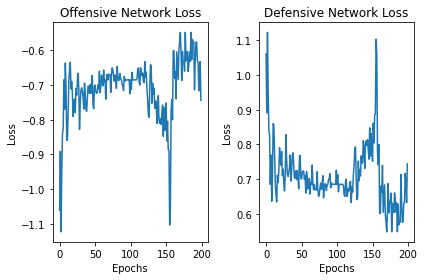

In [10]:
%matplotlib inline

plt.subplot(121)
plt.plot(np.arange(len(losses_o)), losses_o)
plt.title('Offensive Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(np.arange(len(losses_d)), losses_d)
plt.title('Defensive Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

O Loss: -0.4366278052330017, D Loss: 0.4366278052330017



<IPython.core.display.Javascript object>


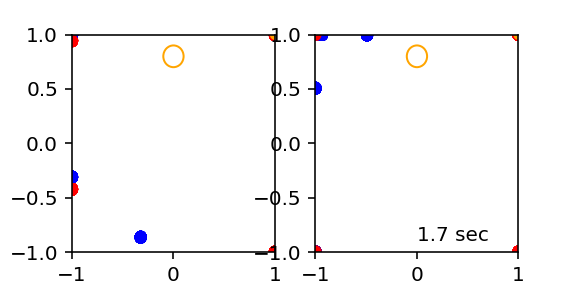

In [12]:
init_game_state = random_initial_game_state(batch_size=2)
all_game_states = run_simulation(model_o, model_d, init_game_state, pbar=tqdm())

loss_o, loss_d = loss_function(all_game_states)
print(f'O Loss: {loss_o.item()}, D Loss: {loss_d.item()}')


%matplotlib notebook
anim = show_game_animation(all_game_states)

# Loss Function Visuals

torch.Size([1, 1, 2])
torch.Size([1, 5, 2])
torch.Size([1, 1])
Points per Possession:  1.1204897165298462


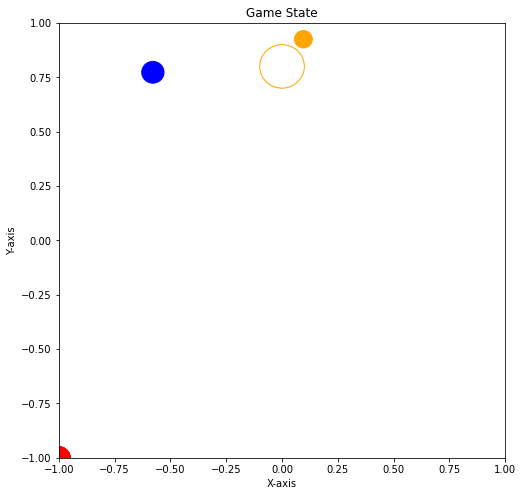

In [21]:
last_game_state = torch.rand(1, 11, 2)*2-1.
last_game_state[:, 1:5, :] = -1
last_game_state[:, 5:10, :] = -1 #last_game_state[:, :1, :]+torch.rand(1, 5, 2)-0.5
pos_op = last_game_state[:, :1, :]
pos_dp = last_game_state[:, idxs_dp, :]

print(pos_op.shape)
print(pos_dp.shape)

ppp = loss_shot(pos_op, pos_dp)
print(ppp.shape)

print('Points per Possession: ', ppp.item())

show_game_state(last_game_state[0])
plt.show()

In [22]:
last_game_state = all_game_states[:, -1, ...]
pos_op = last_game_state[:, :1, :]
pos_dp = last_game_state[:, idxs_dp, :]
loss_shot(pos_op, pos_dp).shape

NameError: name 'all_game_states' is not defined

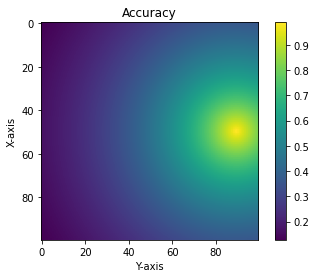

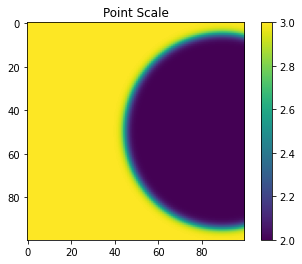

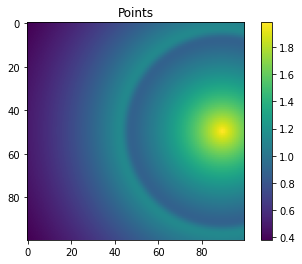

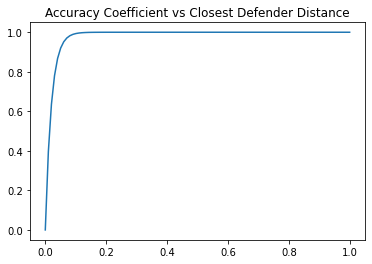

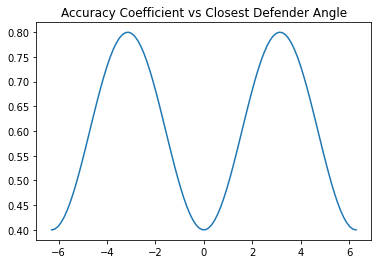

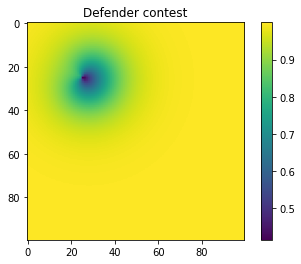

In [19]:
%matplotlib inline

resolution = 100
x, y = torch.meshgrid(torch.linspace(-1, 1, resolution), torch.linspace(-1,1, resolution))
pos_grid = torch.stack((x, y), dim=-1)


raw_acc = raw_accuracy(pos_grid)
plt.imshow(raw_acc.numpy())
plt.xlabel('Y-axis')
plt.ylabel('X-axis')
plt.title('Accuracy')
plt.colorbar()
plt.show()


ps = raw_points(pos_grid)
plt.imshow(ps.numpy())
plt.title('Point Scale')
plt.colorbar()
plt.show()


plt.imshow((ps*raw_acc).numpy())
plt.title('Points')
plt.colorbar()
plt.show()


d = torch.linspace(0, 1, 100)
cont = raw_contest_distance(d)
plt.plot(d.numpy(), cont.numpy())
plt.title('Accuracy Coefficient vs Closest Defender Distance')
plt.show()


d = torch.linspace(-2*np.pi, 2*np.pi, 100)
cont = raw_contest_angle(d)
plt.plot(d.numpy(), cont.numpy())
plt.title('Accuracy Coefficient vs Closest Defender Angle')
plt.show()

pos_op = torch.tensor([-0.5,-0.5])
cont = contest(pos_op, pos_grid)
plt.imshow(cont.numpy())#, vmin=0, vmax=1)
plt.title('Defender contest')
plt.colorbar()
plt.show()


